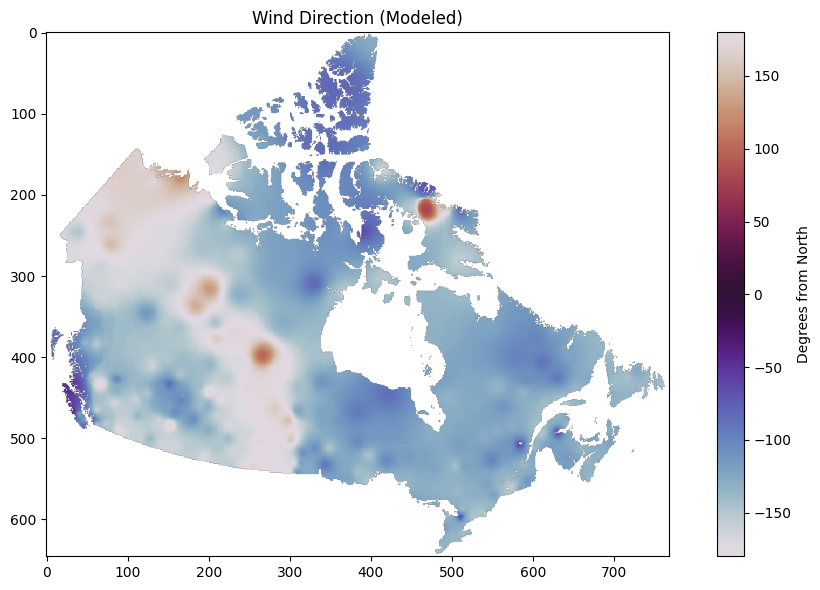

In [9]:
import requests
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show


local_path = "public_fwi20230604.tif"

with rasterio.open(local_path) as src:
    data = src.read(1)
    nodata = src.nodata or -3.4028235e+38
    data = np.where(data == nodata, np.nan, data)

plt.figure(figsize=(10, 6))
img = plt.imshow(data, cmap="twilight", vmin=-180, vmax=180)
plt.colorbar(img, label="Degrees from North")
plt.title("Wind Direction (Modeled)")
plt.tight_layout()
plt.show()

⬇️ Downloading Fire Danger Rating GeoTIFF...
✅ File saved.
CRS: EPSG:3978
Shape: (646, 768)
Unique values: [0. 1. 2. 3. 4.]


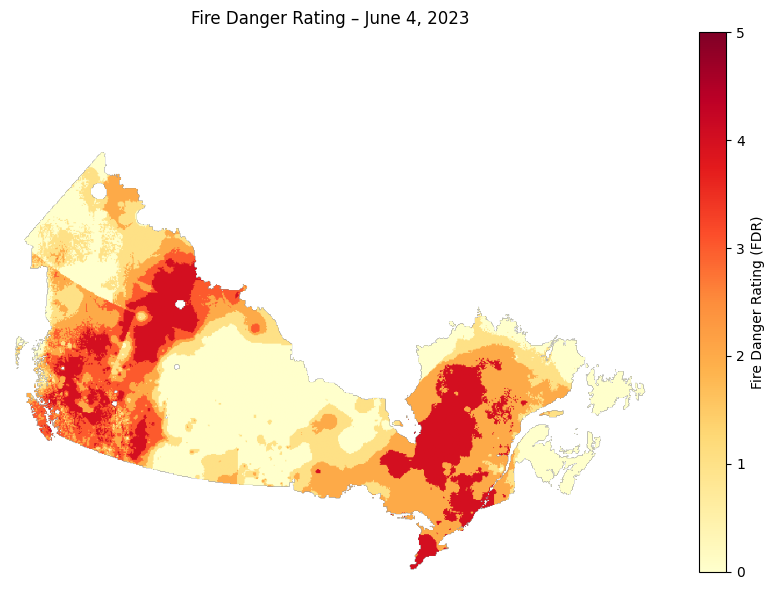

In [10]:
# Step 1: Download the GeoTIFF for FDR
url = (
    "https://cwfis.cfs.nrcan.gc.ca/geoserver/public/wcs?"
    "service=WCS&version=1.0.0&request=GetCoverage&"
    "coverage=public:fdr20230604&"
    "BBOX=-2378164,-707617,3039835,3854382&"
    "WIDTH=768&HEIGHT=646&CRS=EPSG:3978&FORMAT=geotiff"
)

local_path = "fdr_20230604.tif"
print("⬇️ Downloading Fire Danger Rating GeoTIFF...")
response = requests.get(url)
response.raise_for_status()
with open(local_path, "wb") as f:
    f.write(response.content)
print("✅ File saved.")

# Step 2: Open and inspect raster data
with rasterio.open(local_path) as src:
    band = src.read(1)
    nodata = src.nodata or -3.4028235e+38
    band = np.where(band == nodata, np.nan, band)

    print(f"CRS: {src.crs}")
    print(f"Shape: {band.shape}")
    print(f"Unique values: {np.unique(band[~np.isnan(band)])}")

# Step 3: Visualize the FDR raster
plt.figure(figsize=(10, 6))
img = plt.imshow(band, cmap="YlOrRd", vmin=0, vmax=5)  # Categorical fire danger scale: 1–5 (sometimes 0–6)
plt.colorbar(img, label="Fire Danger Rating (FDR)")
plt.title("Fire Danger Rating – June 4, 2023")
plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
import rasterio
import numpy as np
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# Load raster and extract non-nodata values
with rasterio.open("fdr_20230604.tif") as src:
    band = src.read(1)
    nodata = src.nodata or -3.4028235e+38
    mask = band != nodata
    transform = src.transform
    crs = src.crs

print(crs)

# Convert to vector shapes (geometry + value)
results = (
    {"geometry": shape(geom), "value": value}
    for geom, value in shapes(band, mask=mask, transform=transform)
)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame.from_records(results, columns=["geometry", "value"])
gdf.set_geometry("geometry", inplace=True)
gdf.set_crs(crs, inplace=True)  # Set CRS separately for compatibility

# Simplify for demo: sample only first 100 polygons
sample_gdf = gdf.sample(n=100, random_state=42)

# Display first few
print(sample_gdf.head())

EPSG:3978
                                               geometry  value
1933  POLYGON ((-1750296.928 591775.904, -1750296.92...    3.0
831   POLYGON ((2136835.167 1093172.079, 2136835.167...    0.0
1353  POLYGON ((-1637421.949 676518.92, -1637421.949...    3.0
982   POLYGON ((2630663.201 951933.72, 2630663.201 9...    0.0
1788  POLYGON ((1530132.154 429351.791, 1530132.154 ...    4.0


In [18]:
sample_gdf.to_file("fdr_sample_polygons.geojson", driver="GeoJSON")
print("✅ Exported to fdr_sample_polygons.geojson")


✅ Exported to fdr_sample_polygons.geojson


In [24]:
import requests
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes

# Step 1: Download the GeoTIFF for Relative Humidity
url = (
    "https://cwfis.cfs.nrcan.gc.ca/geoserver/public/wcs?"
    "service=WCS&version=1.0.0&request=GetCoverage&"
    "coverage=public:rh_current"
    "BBOX=-2378164,-707617,3039835,3854382&"
    "WIDTH=768&HEIGHT=646&CRS=EPSG:3978&FORMAT=geotiff"
)
local_path = "rh_current.tif"

print("⬇️ Downloading RH GeoTIFF...")
response = requests.get(url)
response.raise_for_status()
with open(local_path, "wb") as f:
    f.write(response.content)
print("✅ File saved:", local_path)

# Step 2: Open and inspect raster data
with rasterio.open(local_path) as src:
    band = src.read(1)
    nodata = src.nodata or -3.4028235e+38
    mask = band != nodata
    band = np.where(mask, band, np.nan)
    transform = src.transform
    crs = src.crs

    print(f"CRS: {crs}")
    print(f"Shape: {band.shape}")
    print(f"Unique values: {np.unique(band[~np.isnan(band)])[:10]}")

# Step 3: Vectorize (raster → polygons)
results = (
    {"geometry": shape(geom), "value": value}
    for geom, value in shapes(band, mask=mask, transform=transform)
)

# Step 4: Create GeoDataFrame
gdf = gpd.GeoDataFrame.from_records(results, columns=["geometry", "value"])
gdf.set_geometry("geometry", inplace=True)
gdf.set_crs(crs, inplace=True)

# Optional: Save as GeoJSON
gdf.to_file("rh_20230604.geojson", driver="GeoJSON")
print("✅ GeoJSON saved: rh_20230604.geojson")

# Optional: Visualize
plt.figure(figsize=(10, 6))
img = plt.imshow(band, cmap="Blues", vmin=0, vmax=100)
plt.colorbar(img, label="Relative Humidity (%)")
plt.title("Relative Humidity – June 4, 2023")
plt.axis("off")
plt.tight_layout()
plt.show()


⬇️ Downloading RH GeoTIFF...
✅ File saved: rh_current.tif


RasterioIOError: 'rh_current.tif' not recognized as being in a supported file format.